# Paper Model

Every Spacetime frame is passed to a pretrained Image Classifier (ResNet50), and its embedding is extracted. These embeddings are stacked along the temporal axis and fed into an LSTM. The output of a single LSTM cell is a 42 vector, which are again stacked along the temporal axis to create a cochleagram. Reconstruction loss is computed between the predicted cochleagram and the true cochleagram and the loss is backpropagated to train the network.

This notebook loads the trained model from the checkpoint directory and reconstructs a wave from the output of the network.

In [1]:
import sys

sys.path.append('../..')

import torch
import pytorch_lightning as pl

from torch.utils.data import DataLoader

from VISTorchUtils import VISDataset, VISLoss
from VISDataPoint import VISDataPoint
from utils import visCollate, waveFromCochleagram

from VISBiLSTMModel import VISBiLSTMModel
import matplotlib.pyplot as plt

from IPython.display import Audio

In [2]:
trainDataset = VISDataset('/scratch/vis_data/train')
valDataset = VISDataset('/scratch/vis_data/test')

In [3]:
BATCH_SIZE=4
NUM_WORKERS = 2

In [4]:
trainDataLoader = DataLoader(trainDataset, batch_size=BATCH_SIZE, collate_fn=visCollate, shuffle=True, num_workers=NUM_WORKERS)
valDataLoader = DataLoader(valDataset, batch_size=BATCH_SIZE, collate_fn=visCollate, shuffle=True, num_workers=NUM_WORKERS)

In [5]:
model = VISBiLSTMModel.load_from_checkpoint('model_weights/bilstm-model-epoch=39-val_loss=0.00.ckpt', outputSize=42, isBi=True)

/home2/arihanth.srikar/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [6]:
coch, stFrames, frame0, material = next(iter(valDataLoader))
coch_pred = model(stFrames, frame0)[0].detach().cpu()

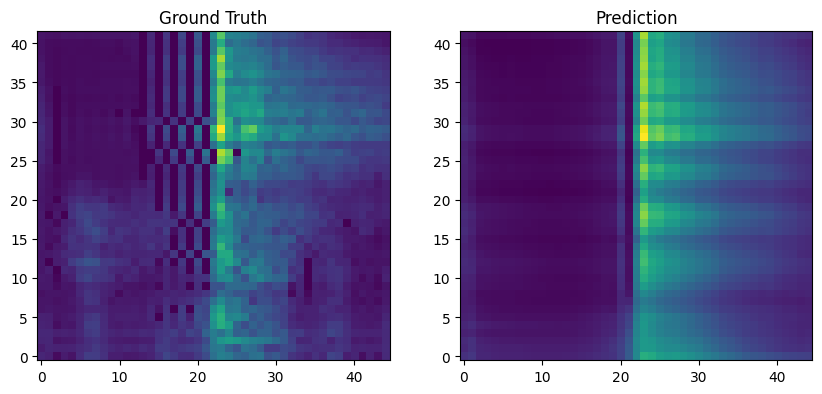

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].imshow(coch[0].detach().cpu(), origin='lower')
axs[0].set_title('Ground Truth')
axs[1].imshow(coch_pred, origin='lower')
axs[1].set_title('Prediction')
plt.show()

In [8]:
print(torch.norm(coch[0] - coch_pred))

tensor(1.8486)


In [9]:
wav = waveFromCochleagram(coch_pred.numpy())
wav_gt = waveFromCochleagram(coch[0].numpy())

In [10]:
wav

array([-6.02282030e-06,  3.64816457e-05,  1.02831537e-05, ...,
        2.50594674e-05,  3.35516490e-05,  3.58315214e-05])

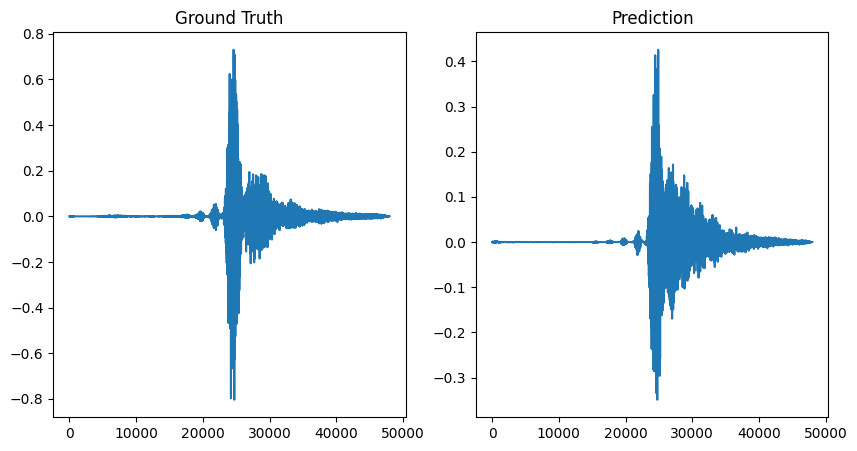

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(range(wav_gt.shape[0]), wav_gt)
axs[0].set_title('Ground Truth')
axs[1].plot(range(wav.shape[0]), wav)
axs[1].set_title('Prediction')

plt.show()

In [12]:
Audio(wav_gt, rate=96000)

In [13]:
Audio(wav, rate=96000)